## **AI-Based Structural Damage Detection Using Deep Learning (MobileNetV2)**










In [ ]:
# import the important librearies

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. SETUP DATA GENERATORS (Repeat this to ensure fresh data flow)
data_path = '/content/drive/MyDrive/Colab Notebooks/Structural_Damage_Classification/test' # Update this!

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=30, # More rotation helps the AI see cracks at any angle
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 2. BUILD THE MODEL WITH UNFROZEN LAYERS
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze the base model
base_model.trainable = True

# Refreeze everything EXCEPT the last 30 layers
# This allows the model to learn specific highway/building textures
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Increased dropout to prevent it from "memorizing"
    layers.Dense(1, activation='sigmoid')
])

# 3. RE-COMPILE WITH A VERY LOW LEARNING RATE
# This is critical. A high learning rate will "break" the pre-trained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. CALCULATE CLASS WEIGHTS (Based on your numbers)
# Since you have ~3x more Non-Damaged, we weight Damaged (Index 0) by 3.0
class_weights = {0: 3.0, 1: 1.0}

# 5. TRAIN
print("Starting Fine-Tuning...")
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weights
)

# 6. SAVE THE NEW BRAIN
model.save("damage_model_tf")  # folder

print("Model Saved!")

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting Fine-Tuning...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 193s 12s/step - accuracy: 0.6123 - loss: 1.5300 - val_accuracy: 0.5667 - val_loss: 0.7362
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6637 - loss: 1.4000 - val_accuracy: 0.6083 - val_loss: 0.6878
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6975 - loss: 1.2498 - val_accuracy: 0.5667 - val_loss: 0.6868
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7550 - loss: 1.0695 - val_accuracy: 0.5417 - val_loss: 0.7103
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8206 - loss: 0.8859 - val_accuracy: 0.6333 - val_loss: 0.7050
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8098 - loss: 0.7746 - val_accuracy: 0.6583 - val_loss: 0.6797
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8537 - loss: 0.7111 - val_accuracy: 0.6083 - val_loss: 0.7122
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8487 - loss: 0.6479 - val_accuracy: 0.6083 - val_los

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=damage_model_tf.

In [2]:
model.export("damage_model_tf")   # ✅ folder banega


Saved artifact at 'damage_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138782147312144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144399504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144399888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782147313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782147313488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782147311952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144398544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144400656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144400272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138782144400080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13878214439

In [3]:
!zip -r damage_model_tf.zip damage_model_tf


  adding: damage_model_tf/ (stored 0%)
  adding: damage_model_tf/saved_model.pb (deflated 91%)
  adding: damage_model_tf/variables/ (stored 0%)
  adding: damage_model_tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: damage_model_tf/variables/variables.index (deflated 78%)
  adding: damage_model_tf/assets/ (stored 0%)
  adding: damage_model_tf/fingerprint.pb (stored 0%)


Final Training Accuracy: 94.17%
Final Validation Accuracy: 89.17%


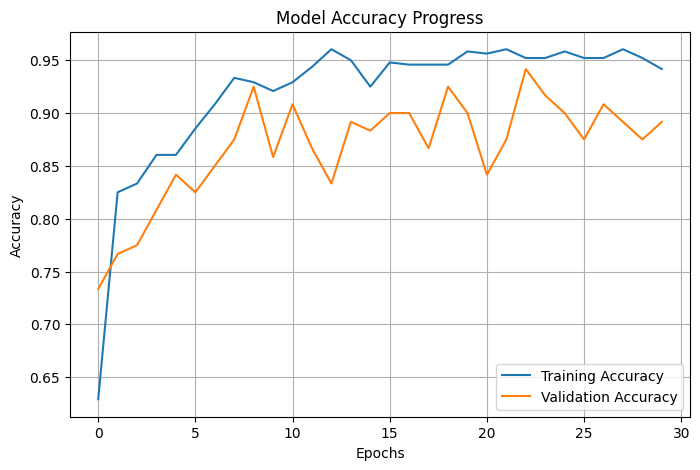

In [ ]:
# Final accuracy from the training history
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

# Plot the accuracy curve to show your professor/examiner
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Raw AI Score: 0.4622
Verdict: ⚠️ DAMAGED
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


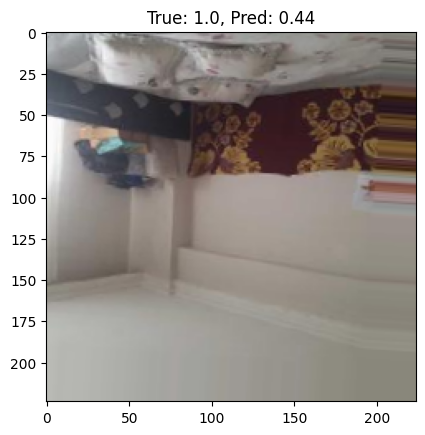

In [ ]:
def test_on_new_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    raw_score = model.predict(x)[0][0]

    print(f"Raw AI Score: {raw_score:.4f}")

    if raw_score < 0.5:
        print("Verdict: ⚠️ DAMAGED")
    else:
        print("Verdict: ✅ NON-DAMAGED")

# Test with an image you know is damaged
test_on_new_image('/content/drive/MyDrive/Colab Notebooks/Structural_Damage_Classification/test/test_Non_Damaged/Non-damaged_highway/5 (757).jpg')


# Code to see which images the model failed on
def show_errors(val_gen, model):
    x, y = next(val_gen)
    preds = model.predict(x)
    for i in range(len(x)):
        if (preds[i] > 0.5) != y[i]:
            plt.imshow((x[i] + 1) / 2)
            plt.title(f"True: {y[i]}, Pred: {preds[i][0]:.2f}")
            plt.show()

show_errors(val_gen, model)

In [ ]:
# This evaluates the model on the data it didn't use for training
results = model.evaluate(val_gen)

print("\n--- Model Performance Report ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Overall Model Accuracy: {results[1] * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9352 - loss: 0.1260

--- Model Performance Report ---
Test Loss: 0.1477
Overall Model Accuracy: 90.83%


In [ ]:
# 1. Reset the generator and TURN OFF SHUFFLE
val_gen.reset()
val_gen.shuffle = False  # Critical: Keep images and labels in the same order
val_gen.index_array = None

# 2. Re-predict
predictions = model.predict(val_gen)
y_pred = (predictions > 0.5).astype(int)
y_true = val_gen.classes # Now this will match the order of predictions

# 3. Print the REAL report
from sklearn.metrics import classification_report, confusion_matrix
target_names = list(val_gen.class_indices.keys())

print("--- CORRECTED Classification Report ---")
print(classification_report(y_true, y_pred, target_names=target_names))

print("--- CORRECTED Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
--- CORRECTED Classification Report ---
                  precision    recall  f1-score   support

    test_Damaged       0.91      0.85      0.88        60
test_Non_Damaged       0.86      0.92      0.89        60

        accuracy                           0.88       120
       macro avg       0.89      0.88      0.88       120
    weighted avg       0.89      0.88      0.88       120

--- CORRECTED Confusion Matrix ---
[[51  9]
 [ 5 55]]
